> Given clinical parameters about a patient, can we predict whether or not they have heart disease?

## Data

The original data came from the Cleavland data from the UCI Machine Learning Repository. https: // archive.ics.uci.edu/ml/datasets/heart+Disease

There is also a version of it available on Kaggle. https: // www.kaggle.com/ronitf/heart-disease-uci

## existing columns in data

1. age - age in years
2. sex - (1 = male; 0 = female)
3. cp - chest pain type
    * 0: Typical angina: chest pain related decrease blood supply to the heart
    * 1: Atypical angina: chest pain not related to heart
    * 2: Non-anginal pain: typically esophageal spasms (non heart related)
    * 3: Asymptomatic: chest pain not showing signs of disease
4. trestbps - resting blood pressure (in mm Hg on admission to the hospital) anything above 130-140 is typically cause for concern
5. chol - serum cholestoral in mg/dl
    * serum = LDL + HDL + .2 * triglycerides
    * above 200 is cause for concern
6. fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
    * '>126' mg/dL signals diabetes
7. restecg - resting electrocardiographic results
    * 0: Nothing to note
    * 1: ST-T Wave abnormality
        * can range from mild symptoms to severe problems
        * signals non-normal heart beat
    * 2: Possible or definite left ventricular hypertrophy
        * Enlarged heart's main pumping chamber
8. thalach - maximum heart rate achieved
9. exang - exercise induced angina (1 = yes; 0 = no)
10. oldpeak - ST depression induced by exercise relative to rest looks at stress of heart during excercise unhealthy heart will stress more
11. slope - the slope of the peak exercise ST segment
    * 0: Upsloping: better heart rate with excercise (uncommon)
    * 1: Flatsloping: minimal change (typical healthy heart)
    * 2: Downslopins: signs of unhealthy heart
12. ca - number of major vessels (0-3) colored by flourosopy
    * colored vessel means the doctor can see the blood passing through
    * the more blood movement the better (no clots)
13. thal - thalium stress result
    * 1,3: normal
    * 6: fixed defect: used to be defect but ok now
    * 7: reversable defect: no proper blood movement when excercising
14. target - have disease or not (1=yes, 0=no) (= the predicted attribute)

In [3]:
# Import all the tools we need

from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# we want our plots to appear inside the notebook
%matplotlib inline


In [4]:
heart_diseace = pd.read_csv('data/heart-disease.csv')

In [5]:
heart_diseace.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1


In [6]:
# Checking if there are NaN values in df
heart_diseace.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

### Trying to find patterns between columns

In [7]:
# comparing sex and target column to check ratio between male and female

pd.crosstab(heart_diseace.sex, heart_diseace.target)

target,0,1
sex,,
0,24,72
1,114,93


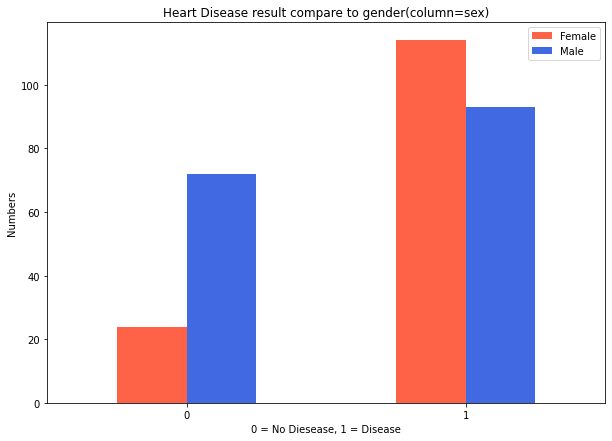

In [8]:
# visulising the crosstab result in a graph

pd.crosstab(heart_diseace.sex, heart_diseace.target).plot(kind='bar',
                                                          figsize=(10, 7),
                                                          color=[
                                                              'tomato', 'royalblue']
                                                          )

plt.title('Heart Disease result compare to gender(column=sex)')
plt.xlabel('0 = No Diesease, 1 = Disease')
plt.ylabel('Numbers')
plt.legend(["Female", "Male"])
plt.xticks(rotation=0)
plt.show()


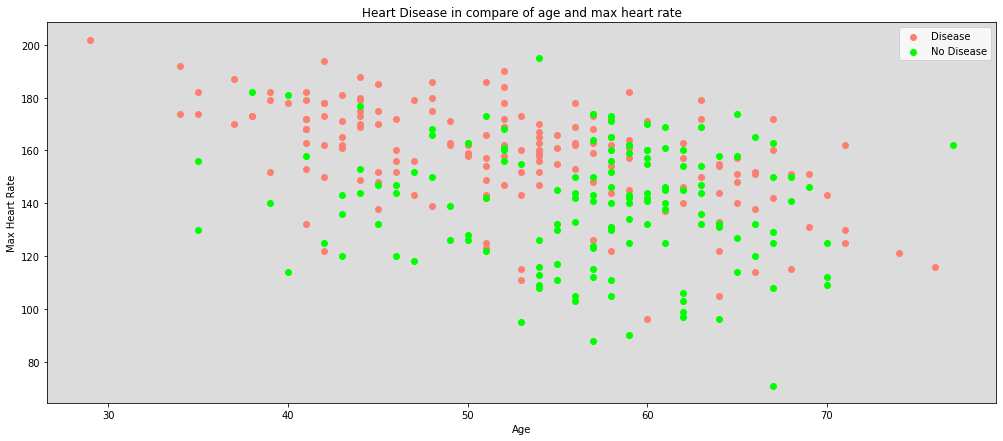

In [9]:
# Finding Relation between thalach(heart rate) and age column
plt.figure(figsize=(17,7))
plt.axes().set_facecolor('gainsboro')

plt.scatter(heart_diseace.age[heart_diseace['target']==1],
            heart_diseace.thalach[heart_diseace['target']==1],
            color='salmon'
)
plt.scatter(heart_diseace.age[heart_diseace['target'] == 0],
            heart_diseace.thalach[heart_diseace['target'] == 0],
            color='lime'
            )
plt.title('Heart Disease in compare of age and max heart rate')
plt.xlabel('Age')
plt.ylabel('Max Heart Rate')
plt.legend(['Disease', 'No Disease'])
plt.show()

* cp - chest pain type
    * 0: Typical angina: chest pain related decrease blood supply to the heart
    * 1: Atypical angina: chest pain not related to heart
    * 2: Non-anginal pain: typically esophageal spasms (non heart related)
    * 3: Asymptomatic: chest pain not showing signs of disease

In [10]:
# Finding relation between column cp and heart disease
pd.crosstab(heart_diseace['cp'],heart_diseace['target'])


target,0,1
cp,,
0,104,39
1,9,41
2,18,69
3,7,16


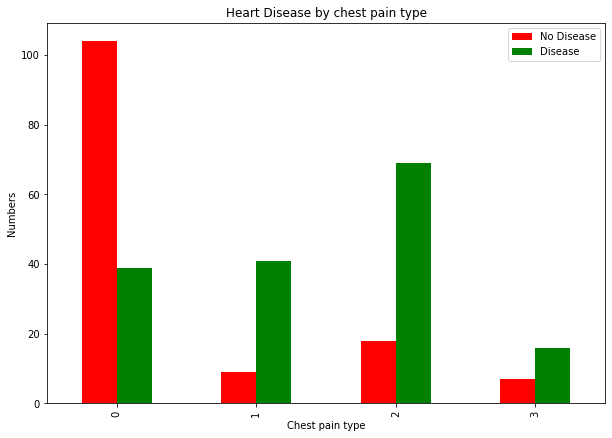

In [11]:
pd.crosstab(heart_diseace['cp'], heart_diseace['target']).plot(kind='bar',
                                                               figsize=(10,7),
                                                               color=['red','green']
)
plt.title('Heart Disease by chest pain type')
plt.xlabel('Chest pain type')
plt.ylabel('Numbers')
plt.legend(['No Disease', 'Disease'])
plt.show()


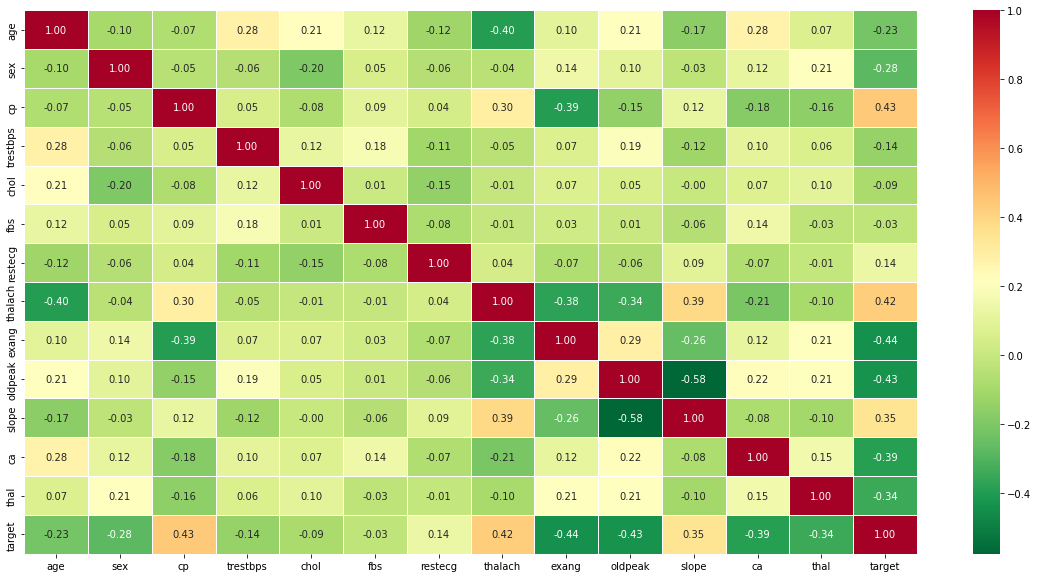

In [12]:
# Making correlation matrix to find relation between the columns
corr_matrix = heart_diseace.corr()
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt='0.2f',
                 cmap='RdYlGn_r'
)


* Trying different models for the project

In [13]:
x = heart_diseace.drop('target', axis=1)
y = heart_diseace['target']


In [22]:
# Making train and test sets
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2)

models = {
    'Logistic Regression': LogisticRegression(max_iter=100),
    'KNN' : KNeighborsClassifier(),
    'Random Forest' : RandomForestClassifier()
}

def model_tester(models, x_train, x_test, y_train, y_test):
    # Settining random seed
    np.random.seed(42)
    model_scores = {}


    for name, model in models.items():
        model.fit(x_train, y_train)
        model_scores[name] = model.score(x_test, y_test)

    return model_scores


In [ ]:
model_scores = model_tester(models, x_train, x_test, y_train, y_test)

In [25]:
model_scores


{'Logistic Regression': 0.8524590163934426,
 'KNN': 0.5737704918032787,
 'Random Forest': 0.8524590163934426}

* Hyperparameter tuning

In [30]:
log_reg_grid = {"C": np.logspace(-4, 4, 30),
                "solver": ["liblinear"]}

gs_log_reg = GridSearchCV(LogisticRegression(),
                          param_grid = log_reg_grid,
                          cv = 5,
                          verbose=True
) 

gs_log_reg.fit(x_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 1.88739182e-04, 3.56224789e-04, 6.72335754e-04,
       1.26896100e-03, 2.39502662e-03, 4.52035366e-03, 8.53167852e-03,
       1.61026203e-02, 3.03919538e-02, 5.73615251e-02, 1.08263673e-01,
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04]),
                         'solver': ['liblinear']},
             verbose=True)

In [31]:
gs_log_reg.best_params_

{'C': 2.592943797404667, 'solver': 'liblinear'}

In [32]:
gs_log_reg.score(x_test, y_test)


0.8360655737704918

In [40]:
# creating the model using best hyper-params
model = LogisticRegression(C= 2.592943797404667, solver = 'liblinear')

cv_accuracy = cross_val_score(model, x, y, cv=5, scoring="accuracy")
cv_accuracy = cv_accuracy.mean()
cv_accuracy


0.8248633879781421

In [42]:
#  cross validated precision
cv_precision = cross_val_score(model, x, y, cv=5, scoring="precision")
cv_precision = cv_precision.mean()
cv_precision


0.8188009641520078

In [43]:
cv_recall = cross_val_score(model, x, y, cv=5, scoring="recall")
cv_recall = cv_recall.mean()
cv_recall


0.8787878787878787

In [44]:
cv_f1 = cross_val_score(model, x, y, cv=5, scoring="f1")
cv_f1 = cv_f1.mean()
cv_f1


0.8464039460644465

In [46]:

cv_metrics = pd.DataFrame({"Accuracy": cv_accuracy,
                           "Precision": cv_precision,
                           "Recall": cv_recall,
                           "F1": cv_f1},
                          index=[0])
cv_metrics

,Accuracy,Precision,Recall,F1
0,0.824863,0.818801,0.878788,0.846404


In [47]:
cv_metrics.T

,0
Accuracy,0.824863
Precision,0.818801
Recall,0.878788
F1,0.846404


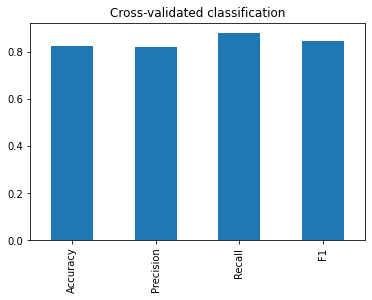

In [50]:
cv_metrics.T.plot.bar(title='Cross-validated classification', legend=False)
plt.show()